In [1]:
#각종 라이브러리를 임포트 해줍시다. 

%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import glob
from PIL import ExifTags
import shutil

In [2]:
#각종 사용할 함수를 세팅합니다.

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "D:/training/"
    testing_dir = "D:/testing/"
    train_batch_size = 64
    train_number_epochs = 10

In [ ]:
# 경로 지정
folder_path = 'D:\\Face_data'
testing_folder = 'D:\\testing'
training_folder = 'D:\\training'

num_samples = 720 # testing 폴더 갯수
random.seed(2023) # 랜덤시드 고정

folders = next(os.walk(folder_path))[1] # D 드라이브에 있는 폴더를 가져오기
random_folders = random.sample(folders, num_samples) # 그 줃 720개의 폴더를 랜덤으로 뽑기

# training과 testing 폴더 생성
os.makedirs(training_folder, exist_ok=True)
os.makedirs(testing_folder, exist_ok=True)

# 랜덤으로 뽑은 폴더이면 testing 폴더에 복사
for folder in random_folders:
    source_path = os.path.join(folder_path, folder)
    destination_path = os.path.join(testing_folder, folder)
    shutil.copytree(source_path, destination_path)

# 랜덤으로 뽑은 폴더 제외하고 나머지는 training 폴더에 복사
for folder in folders:
    if folder not in random_folders:
        source_path = os.path.join(folder_path, folder)
        destination_path = os.path.join(training_folder, folder)
        shutil.copytree(source_path, destination_path)

In [4]:
path = "D:\\testing\\**"
rot_img = []
for f in glob.glob(path, recursive=True):
    try:
        img = Image.open(f)
        exif_data = img._getexif()
        if exif_data[274] != 1:
            print(f, exif_data[274])
            rot_img.append(img)
    except:
        pass

D:\testing\10\0917013_SPI_01_0_00_0_01.jpg 6
D:\testing\8\0917011_SPI_01_0_00_0_01.jpg 6
D:\testing\9\0917012_SPI_01_0_00_0_01.jpg 6


In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert

    def rotate(self, img):
        try:
            if img._getexif()[274] not in [1, 2]:
                orientation = img._getexif()[274]
                
                if orientation == 2:
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 3:
                    img = img.rotate(180)

                elif orientation == 4:
                    img = img.rotate(180).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 5:
                    img = img.rotate(-90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)

                elif orientation == 6:
                    img = img.rotate(-90, expand=True)

                elif orientation == 7:
                    img = img.rotate(90, expand=True).transpose(Image.FLIP_LEFT_RIGHT)
            
            return img
        except:
            return img
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        if img0._getexif() not in [1, 2]:
            img0 = self.rotate(img0)
        
        if img1._getexif() not in [1, 2]:
            img1 = self.rotate(img1)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
#training_dir 경로 안의 모든 파일을 폴더명과 함께 튜플로 저장
folder_dataset = dset.ImageFolder(root=Config.testing_dir)

In [7]:
folder_dataset[4]

(<PIL.Image.Image image mode=RGB size=4032x3024>, 2)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.CenterCrop((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [9]:
siamese_dataset[0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.5059, 0.4902, 0.5176],
          [1.0000, 1.0000, 1.0000,  ..., 0.4902, 0.5020, 0.5059],
          [1.0000, 1.0000, 1.0000,  ..., 0.4902, 0.5020, 0.4627],
          ...,
          [0.8000, 0.7647, 0.7608,  ..., 0.1333, 0.5412, 0.8275],
          [0.7686, 0.7686, 0.7647,  ..., 0.1373, 0.4549, 0.8235],
          [0.7647, 0.7608, 0.7569,  ..., 0.1373, 0.3843, 0.8118]]]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9216, 0.9216, 0.9216],
          [0.9961, 0.9961, 0.9961,  ..., 0.9216, 0.9216, 0.9255],
          [0.9961, 0.9961, 0.9961,  ..., 0.9255, 0.9255, 0.9255],
          ...,
          [0.7804, 0.7882, 0.7922,  ..., 0.3294, 0.3098, 0.3333],
          [0.7882, 0.7922, 0.8000,  ..., 0.3333, 0.2980, 0.3608],
          [0.7882, 0.7882, 0.7922,  ..., 0.3333, 0.3098, 0.3451]]]),
 tensor([1.]))

In [10]:
# 미니배치 생성기
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
# 미니배치 세트 생성
dataiter = iter(vis_dataloader)

In [11]:
dataiter

In [12]:
example_batch = next(dataiter)

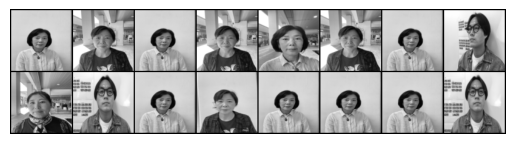

[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [13]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [14]:
torchvision.utils.make_grid(concatenated).shape

torch.Size([3, 206, 818])

In [15]:
# SiameseNetwork1
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
# SiameseNetwork2
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(32*50*50, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),

            nn.Linear(256, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [16]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [19]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.5312470197677612

Epoch number 1
 Current loss 78.10653686523438

Epoch number 2
 Current loss 0.3894994258880615

Epoch number 3
 Current loss 0.1621202826499939

Epoch number 4
 Current loss 353.5182189941406

Epoch number 5
 Current loss 260.7666320800781

Epoch number 6
 Current loss 0.026447385549545288

Epoch number 7
 Current loss 83.63520812988281

Epoch number 8
 Current loss 252.20912170410156

Epoch number 9
 Current loss 105.29473114013672



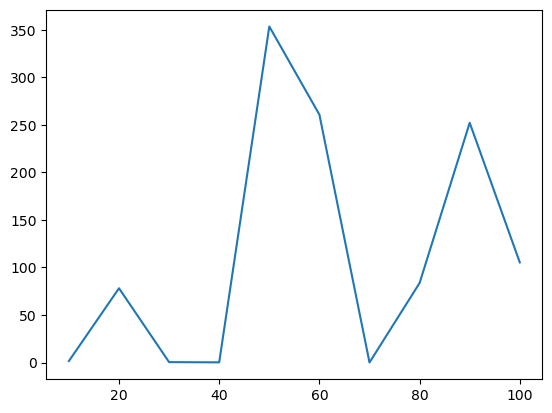

In [20]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

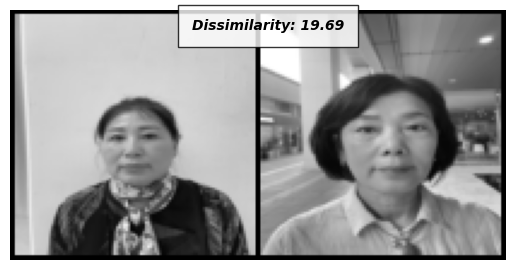

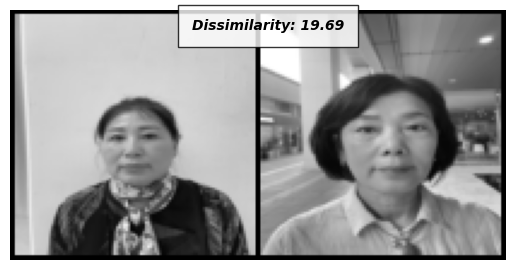

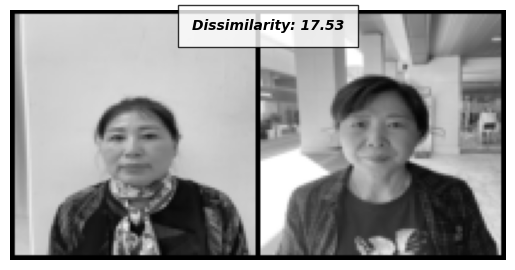

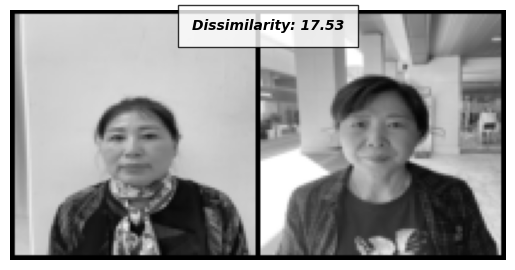

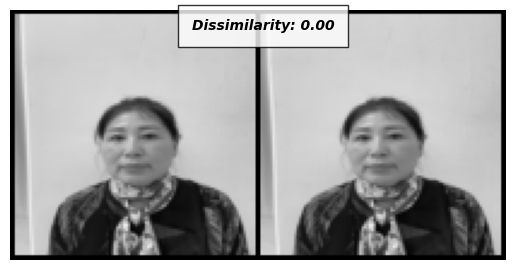

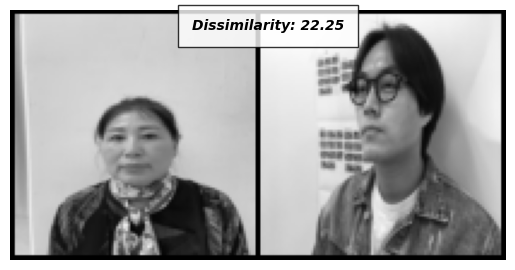

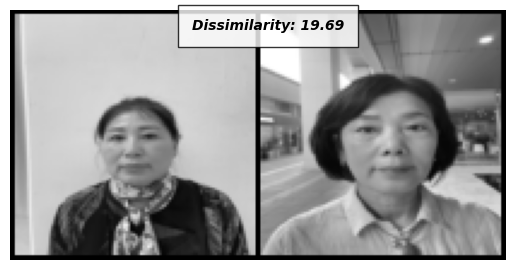

In [21]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(len(dataiter)-1):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))